In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from keras_contrib.layers.crf import CRF
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
import json
from keras import metrics
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


In [2]:
#构建数据列表datas与词表vocabs，sample_x与sample_y为传递数据的中间变量
sample_x = []
sample_y = []
vocabs = {'UNK'}
datas = []
#读取文件数据，‘filename’双引号内为文件路径，数据文件格式为：Word Label
for line in open('/home/wcb/nerXY/train_data/1.0_train.txt', 'r', encoding='utf-8'):
    line = line.rstrip().split('\t')
    if not line:
        continue
    char = line[0]
    if not char:
        continue
    cate = line[-1]
    sample_x.append(char)
    sample_y.append(cate)
    vocabs.add(char)
    if char in ['.', '?', '!']:
        datas.append([sample_x, sample_y])
        sample_x = []
        sample_y = []
word_dict = {wd:index for index,wd in enumerate(list(vocabs))}

In [3]:
#每一次程序运行都会更新词表的顺序！！！
#记录词表vocabs中词语的顺序，后续运行模型时需要调取对应的词表，''内为词表路径
file = open('/home/wcb/nerXY/word_dict/1.0_word_dict.txt', 'w') 
for k,v in word_dict.items():
    file.write(str(v) + ' ' + str(k) + '\n')
file.close()

In [4]:
#构建标签词典
class_dict = {'O':0,
              'I-MC':1,
              'I-PCC':2,
              'I-DTS':3
             }
#构建模型输入的训练数据，用数字代表标签种类
x_train = [[word_dict[char] for char in data[0]] for data in datas]
y_train = [[class_dict[label] for label in data[1]] for data in datas]
#此处设置最大句长 maxlen
x_train = pad_sequences(x_train, maxlen=40, padding='post')
y = pad_sequences(y_train, maxlen=40, padding='post')
y_train = np.expand_dims(y, axis=2)

In [5]:
#导入词向量文件，''内为文件路径
embeddings_dict = {}
with open('/home/wcb/nerXY/w2v/1.0_w2v.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split(' ')
        #72为词向量长度，使用不同词向量维数时应修改
        if len(values) < 72:
            continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
print('Found %s word vectors.' % len(embeddings_dict))

#构建词向量矩阵，np.zeros((len(word_dict) + 1, 72))中的72为词向量长度，使用不同词向量维数时应修改
embedding_matrix = np.zeros((len(word_dict) + 1, 72))
for word, i in word_dict.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 3796 word vectors.


In [6]:
#构建模型
model = Sequential()
#词向量层，72为词向量长度，使用不同词向量维数时应修改，input_length=40为最大句长，最大句长不同时应做相应修改
embedding_layer = Embedding(len(word_dict) + 1,
                            72,
                            weights=[embedding_matrix],
                            input_length=40,
                            trainable=False,
                            mask_zero=True)
model.add(embedding_layer)
#8为神经元个数
model.add(Bidirectional(LSTM(8, return_sequences=True,  activation='softsign')))
#dropout层防止过拟合
model.add(Dropout(0.5))
#全连接层
model.add(TimeDistributed(Dense(len(class_dict))))
#CRF层
crf_layer = CRF(len(class_dict), sparse_target=True)
model.add(crf_layer)
model.compile(optimizer='AdaGrad', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
model.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-31
OMP: Info #156: KMP_AFFINITY: 32 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 16 cores/pkg x 2 threads/core (16 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to package 0 core 0 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 16 maps to package 0 core 0 thread 1 
OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to package 0 core 1 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 17 maps to package 0 core 1 thread 1 
OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to package 0 core 2 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 18 maps to package 0 core 2 thread 1 
OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to package 0 core 3 thread 0 
OMP: Info #171: KMP_AFFI


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/home/wcb/.local/lib/python3.7/site-packages/keras_contrib-2.0.8-py3.7.egg/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
/home/wcb/.local/lib/python3.7/site-packages/keras_contrib-2.0.8-py3.7.egg/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 72)            273528    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 16)            5184      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 16)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 4)             68        
_________________________________________________________________
crf_1 (CRF)                  (None, 40, 4)             44        
Total params: 278,824
Trainable params: 5,296
Non-trainable params: 273,528
_________________________________________________________________


In [7]:
#模型训练，x_train[:], y_train[:]为训练数据，validation_split=0.10表示分出10%数据用作验证
history = model.fit(x_train[:], y_train[:], validation_split=0.10, batch_size=64, epochs=10)



Train on 3373 samples, validate on 375 samples
Epoch 1/10
  64/3373 [..............................] - ETA: 4:08 - loss: 2.9872 - crf_viterbi_accuracy: 0.4598

OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4012 thread 1 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4019 thread 2 bound to OS proc set 2
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4020 thread 3 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4021 thread 4 bound to OS proc set 4
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4022 thread 5 bound to OS proc set 5
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4023 thread 6 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4024 thread 7 bound to OS proc set 7
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4025 thread 8 bound to OS proc set 8
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4026 thread 9 bound to OS proc set 9
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4027 thread 10 bound to OS proc set 10
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4028 thread 11 bound to OS proc set 11
OMP: Info #250: KMP_AFFINITY: pid 3878 tid 4029 thread 12 bound to OS proc set 12
OMP: Info #250: KMP_AFFINITY: pid 

3373/3373 [==============================] - 12s 4ms/step - loss: 2.5701 - crf_viterbi_accuracy: 0.7717 - val_loss: 2.3624 - val_crf_viterbi_accuracy: 0.7528
Epoch 2/10
3373/3373 [==============================] - 6s 2ms/step - loss: 2.5026 - crf_viterbi_accuracy: 0.7775 - val_loss: 2.3318 - val_crf_viterbi_accuracy: 0.7528
Epoch 3/10
3373/3373 [==============================] - 6s 2ms/step - loss: 2.4724 - crf_viterbi_accuracy: 0.7777 - val_loss: 2.3044 - val_crf_viterbi_accuracy: 0.7528
Epoch 4/10
3373/3373 [==============================] - 6s 2ms/step - loss: 2.4474 - crf_viterbi_accuracy: 0.7785 - val_loss: 2.2798 - val_crf_viterbi_accuracy: 0.7528
Epoch 5/10
3373/3373 [==============================] - 7s 2ms/step - loss: 2.4268 - crf_viterbi_accuracy: 0.7788 - val_loss: 2.2553 - val_crf_viterbi_accuracy: 0.7528
Epoch 6/10
3373/3373 [==============================] - 6s 2ms/step - loss: 2.4075 - crf_viterbi_accuracy: 0.7790 - val_loss: 2.2294 - val_crf_viterbi_accuracy: 0.7528
Ep

(1.7, 2.7)

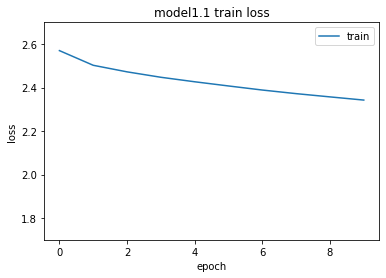

In [8]:
#绘制loss图像
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.title('model1.1 train loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train'], loc='upper right')
pyplot.ylim([1.7,2.7])

In [13]:
#保存模型
model.save('/home/wcb/nerXY/model/model1.0.h5')